In [19]:
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm 

plt.rcParams['figure.dpi'] = 500

## Exploration

In [2]:
%%capture
model = RobertaModel.from_pretrained('roberta-base').embeddings.word_embeddings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
data = model.weight

In [4]:
U, S, V = torch.pca_lowrank(data, q=10)

In [110]:
data2p = torch.matmul(data, V[:, 5:7])

### Upload words

In [93]:
filename = "list_words.txt"
init_words = set(map(str.strip, open(filename).readlines()))
init_words = list(filter(lambda item: len(tokenizer.encode(item)) == 3, init_words))
print(f"number of words: {len(init_words)}")

number of words: 1617


In [115]:
words = random.sample(init_words, 50)

In [116]:
indices = torch.LongTensor([tokenizer.encode(token)[1] for token in words])

In [117]:
embeddings = [(token, data2p[idx][0].item(), data2p[idx][1].item()) for token, idx in zip(words, indices)]
embeddings = pd.DataFrame(data=embeddings, columns=["word", "x1", "x2"])

<Figure size 10000x10000 with 0 Axes>

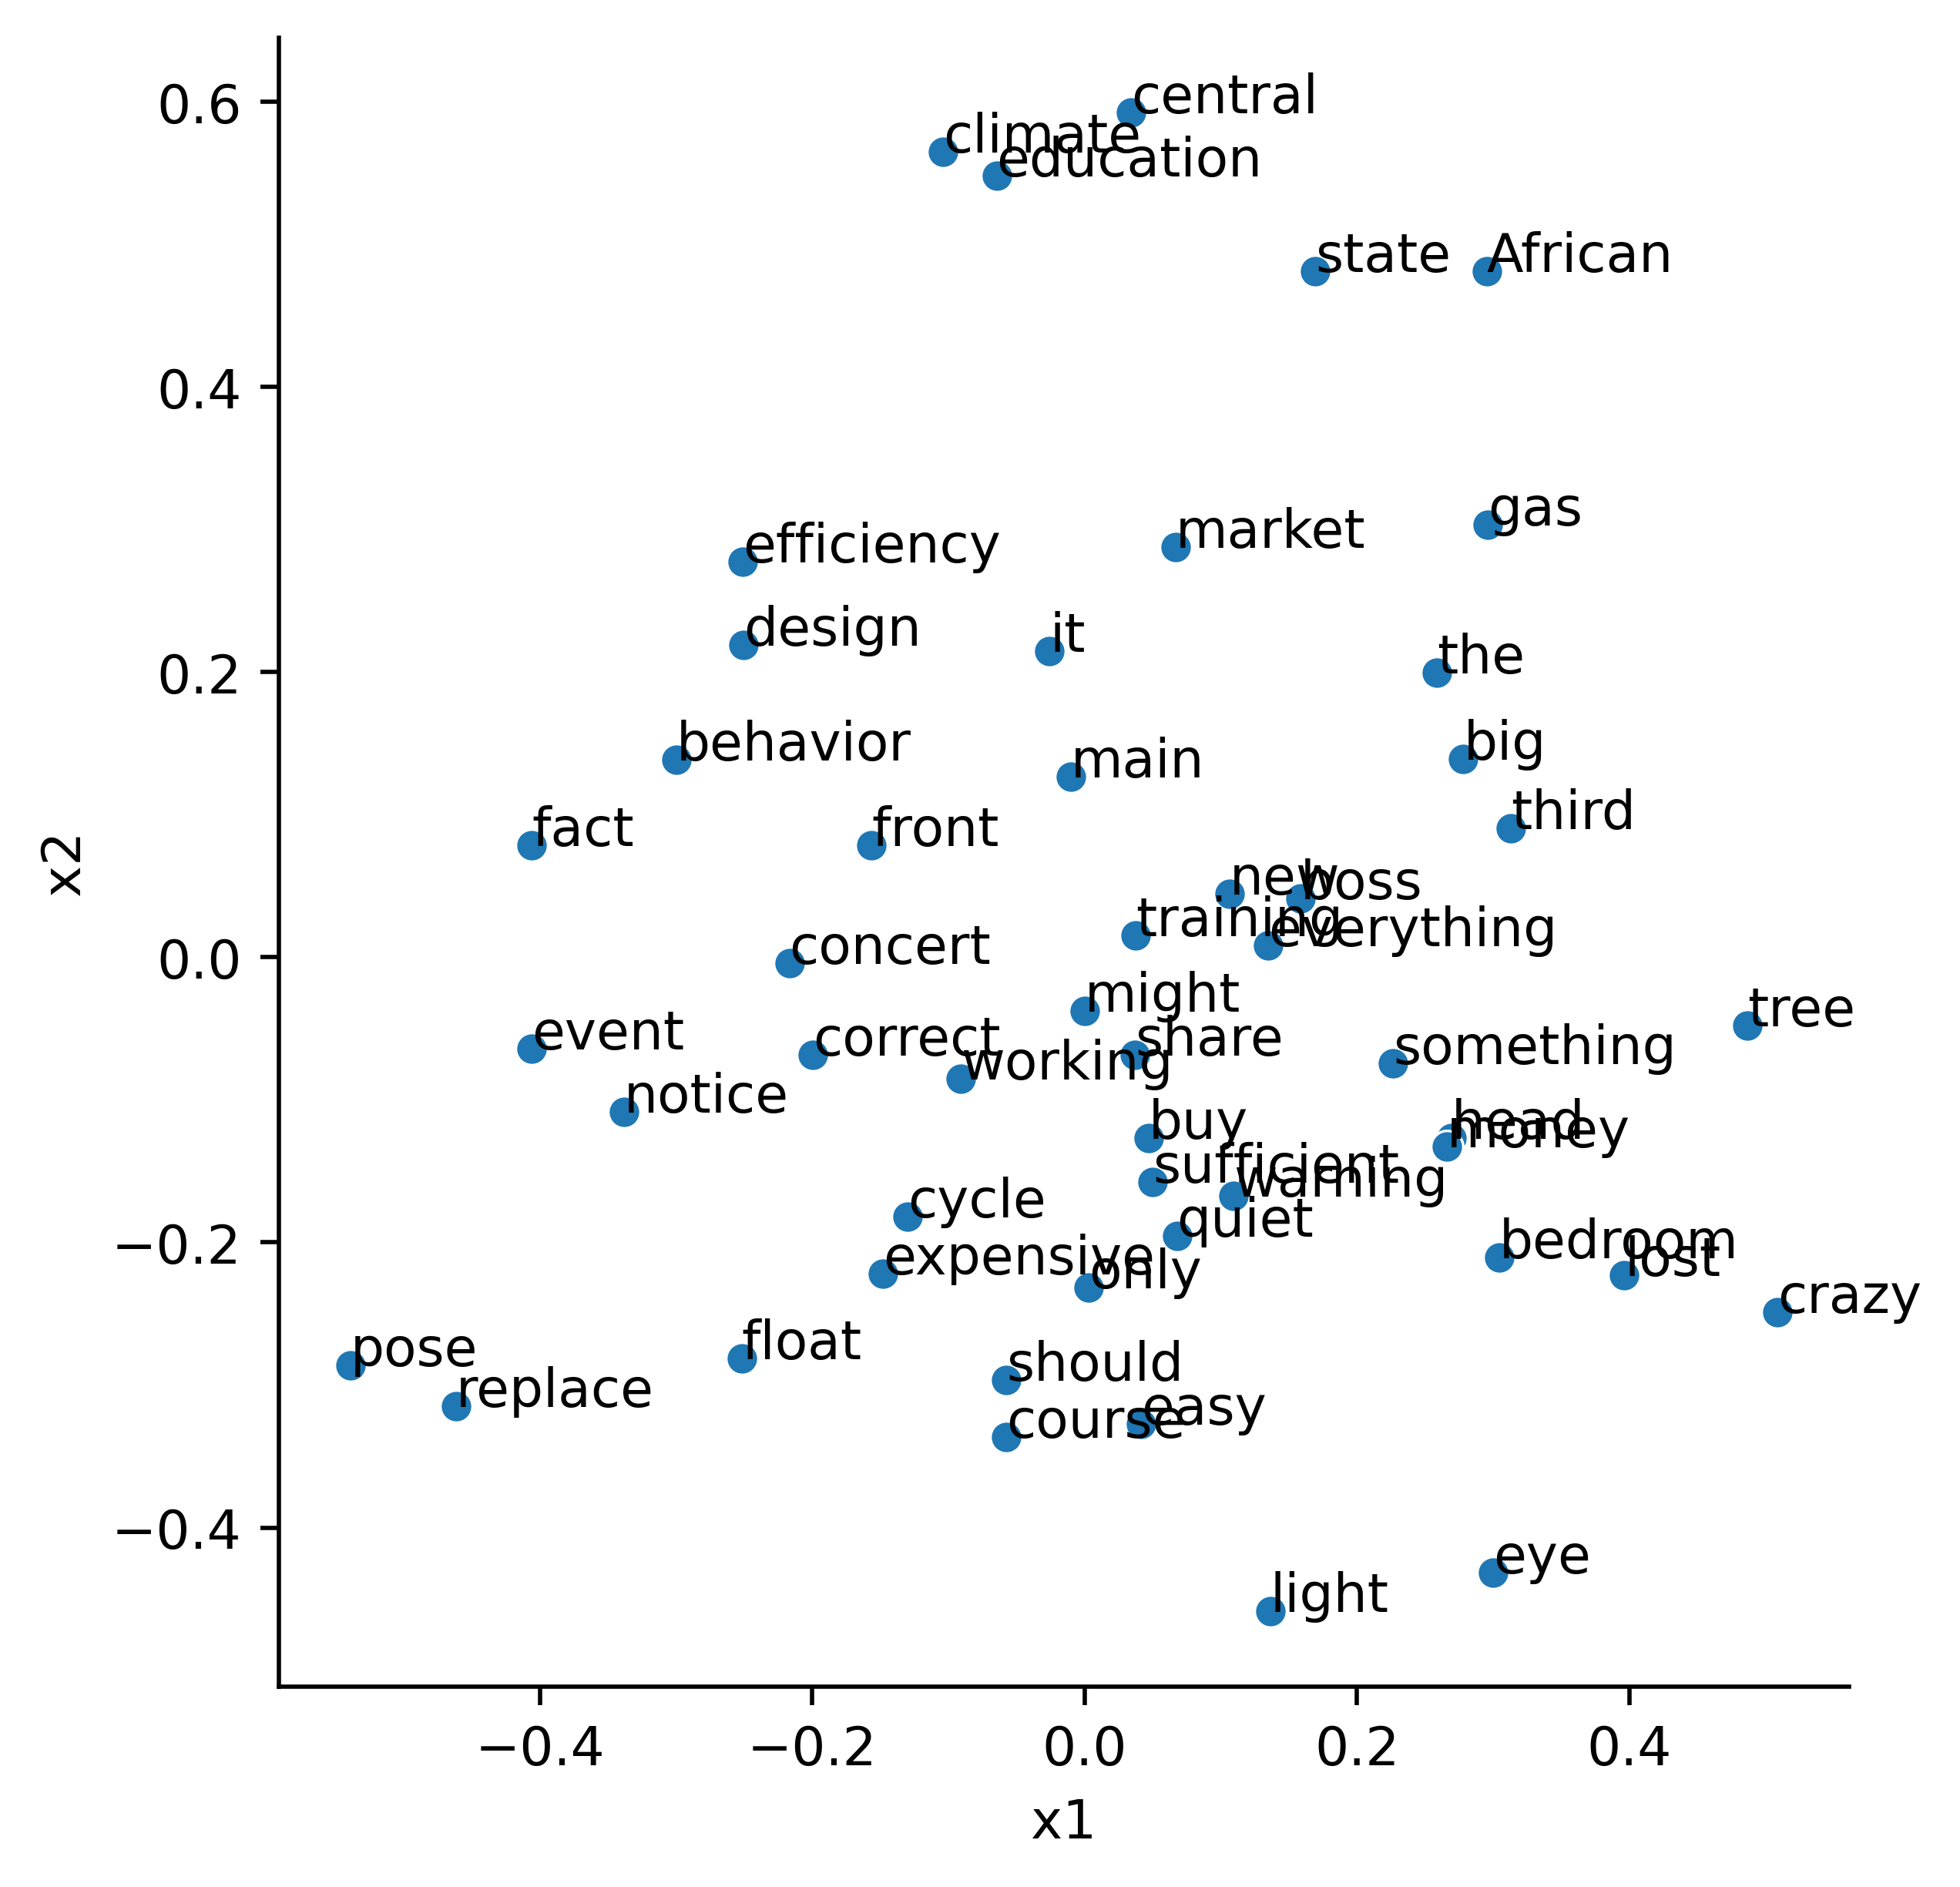

In [118]:
plt.figure(figsize=(20, 20))
sns.relplot(data=embeddings, x="x1", y="x2")
for _, row in embeddings.iterrows():
    plt.text(row["x1"], row["x2"], row["word"])

## Local Action Building

In [13]:
def buildActionSet(embedding: torch.Tensor, output_file: str, tokenizer: AutoTokenizer, k: int = 10, factor: int = 10, name: bool = True):
    out = []
    topk = k * factor
    for idx in tqdm(range(embedding.shape[0])):
        corr = torch.matmul(embedding, embedding[idx, :].reshape(-1, 1)).reshape(-1)
        related_tokens = corr.topk(topk)[-1].tolist()
        related_tokens = {tokenizer.decode(token).lower().strip(): 1 for token in related_tokens}
        if name:
            related_tokens = [token for token in list(related_tokens.keys())[:10]]
        else:
            related_tokens = [tokenizer.encode(token)[1] for token in list(related_tokens.keys())[:10]]
        token = tokenizer.decode(idx)
        out.append((idx, token, related_tokens))
    
    out = pd.DataFrame(data=out, columns=["index", "token", "close tokens"])
    out.to_csv(output_file, index=False)

In [3]:
%%capture
data = RobertaModel.from_pretrained('roberta-base').embeddings.word_embeddings.weight
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
buildActionSet(data, "local_action_index.csv", tokenizer, name=False)

100%|██████████| 50265/50265 [10:10<00:00, 82.30it/s]


In [ ]:
buildActionSet(data, "local_action_name.csv", tokenizer, name=True)